Apply the thermodynamic bethe ansatz to a non-integrable system - longitidunal ising. We calculate the S-matrix numerically, and then naively plug in the TBA equations, which will give us the energy density.

If you're wondering how the S-matrix can be calculated, look at the Smatrix.ipynb notebook which discusses this in far more detail.

In [1]:
using Revise,MPSKit, TensorKit, MPSKitExperimental, MPSKitModels, Plots, KrylovKit

In [2]:
longit = 0.5
transvers = 2

th = @mpoham sum(-S_xx(){i, i + 1} + transvers * S_z(){i}  + longit * S_x(){i} for i in vertices(InfiniteChain()))
ts = InfiniteMPS(th.pspaces,[ℂ^8]);
(ts,gs_env) = find_groundstate(ts,th,VUMPS(maxiter=200,verbose=false));

┌ Warning: VUMPS maximum iterations
│   iter = 200
│   ϵ = 8.725003400027059e-10
│   λ = -1.0156870128527506 - 2.2938596166178737e-17im
└ @ MPSKit /home/maarten/projects/MPSKit.jl/src/algorithms/groundstate/vumps.jl:94


In [3]:
# how does the dispersion relation look?
kspace = LinRange(-pi,pi,11)
(Es,Bs) = excitations(th,QuasiparticleAnsatz(),kspace,ts,sector = Trivial(),parallel=false);

┌ Info: Found excitations for p = -3.141592653589793
└ @ MPSKit /home/maarten/projects/MPSKit.jl/src/algorithms/excitation/quasiparticleexcitation.jl:96


┌ Info: Found excitations for p = -2.5132741228718345
└ @ MPSKit /home/maarten/projects/MPSKit.jl/src/algorithms/excitation/quasiparticleexcitation.jl:96
┌ Info: Found excitations for p = -1.8849555921538759
└ @ MPSKit /home/maarten/projects/MPSKit.jl/src/algorithms/excitation/quasiparticleexcitation.jl:96


┌ Info: Found excitations for p = -1.2566370614359172
└ @ MPSKit /home/maarten/projects/MPSKit.jl/src/algorithms/excitation/quasiparticleexcitation.jl:96


┌ Info: Found excitations for p = -0.6283185307179586
└ @ MPSKit /home/maarten/projects/MPSKit.jl/src/algorithms/excitation/quasiparticleexcitation.jl:96
┌ Info: Found excitations for p = 0.0
└ @ MPSKit /home/maarten/projects/MPSKit.jl/src/algorithms/excitation/quasiparticleexcitation.jl:96


┌ Info: Found excitations for p = 0.6283185307179586
└ @ MPSKit /home/maarten/projects/MPSKit.jl/src/algorithms/excitation/quasiparticleexcitation.jl:96
┌ Info: Found excitations for p = 1.2566370614359172
└ @ MPSKit /home/maarten/projects/MPSKit.jl/src/algorithms/excitation/quasiparticleexcitation.jl:96


┌ Info: Found excitations for p = 1.8849555921538759
└ @ MPSKit /home/maarten/projects/MPSKit.jl/src/algorithms/excitation/quasiparticleexcitation.jl:96
┌ Info: Found excitations for p = 2.5132741228718345
└ @ MPSKit /home/maarten/projects/MPSKit.jl/src/algorithms/excitation/quasiparticleexcitation.jl:96


┌ Info: Found excitations for p = 3.141592653589793
└ @ MPSKit /home/maarten/projects/MPSKit.jl/src/algorithms/excitation/quasiparticleexcitation.jl:96


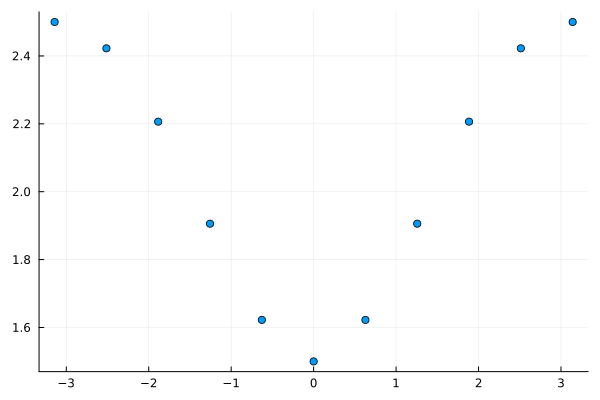

In [4]:
plot(kspace,real.(Es),legend=false,seriestype=:scatter)

In [5]:
function scatter_workflow(A_lg,B_lg,E; len = 10, windowchi = ℂ^10)
    A_rg = convert(RightGaugedQP,A_lg);
    B_rg = convert(RightGaugedQP,B_lg);

    K1 = A_lg.momentum;
    K2 = B_lg.momentum

    BA_asymptotic = AssymptoticScatter(B_lg,A_rg);
    AB_asymptotic = AssymptoticScatter(A_lg,B_rg);

    BA_projected = LeftGaugedMW(rand,len,windowchi,ts,momentum = K1 + K2+0im,utilspace= MPSKit.utilleg(BA_asymptotic));    
    AB_projected = LeftGaugedMW(rand,len,windowchi,ts,momentum = K1 + K2+0im,utilspace= MPSKit.utilleg(BA_projected));

    begin
        (AB_projected,_) = approximate(AB_projected,(th,AB_asymptotic),DMRG(tol=1e-12,maxiter=20,verbose=false));
        (BA_projected,_) = approximate(BA_projected,(th,BA_asymptotic),DMRG(tol=1e-12,maxiter=20,verbose=false));
    end;

        
    B = LeftGaugedMW(rand,1,windowchi,ts,momentum=K1+K2+0im,utilspace=MPSKit.utilleg(AB_projected));

    S = -inv(partialdot(BA_projected,BA_projected))*partialdot(BA_projected,AB_projected)

    envs = environments(B,(th,B),gs_env,gs_env);
    row = 1
    col = 1

    y_1 = -projdown(row,col,AB_projected,B);
    y_2 = -partialdot(BA_asymptotic,AB_projected);

    x_1 = B.AC[row,col];
    x_2 = S;

    (sol,convhist) = linsolve(RecursiveVec((y_1,y_2)),RecursiveVec((x_1,x_2)),GMRES(tol=1e-9)) do x
        (c_B,c_S) = x.vecs;
        B.AC[row,col] = c_B;
        envs = environments(B,(th,B),gs_env,gs_env);
        
        SBA_projected = lmul!(c_S,copy(BA_projected))

        v_1 = MPSKit.ac_proj(row,col,B,envs)-E*c_B
        v_1 += projdown(row,col,SBA_projected,B);
        v_2 = partialdot(BA_projected,B)+partialdot(BA_asymptotic,SBA_projected);
        RecursiveVec((v_1,v_2))
    end

    B.AC[row,col] = sol[1];
    S = sol[2];
    return tr(S)
end

scatter_workflow (generic function with 1 method)

In [6]:
Ss = []
for i in 1:11
    push!(Ss,scatter_workflow(Bs[i],Bs[end-i+1],Es[i]+Es[end-i+1]))
end

┌ Warning: dmrg failed to converge 1.2962170485605915e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 2.0901221645414535e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 1.014556081606987e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 3.799637251211996e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 4.789914600849737e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 4.22457752482974e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 1.222985686324219e-6>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 3.9938710187471705e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 5.418347423457722e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 5.532437998321561e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 6.414660400731808e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 5.49499514416214e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 5.605864307781345e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 5.76597347728089e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 5.19158744920909e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 1.0066821967470587e-6>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 3.6968470735668736e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 1.4056966383812938e-6>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 3.1603455674409797e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 9.283752529248344e-8>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 1.7211618955544138e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 3.39655008017086e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


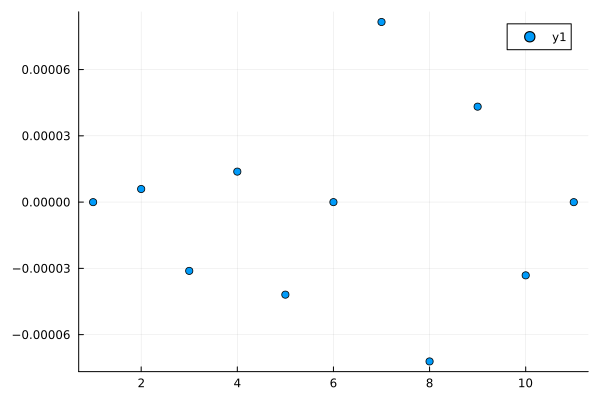

In [7]:
plot(angle.(-Ss),seriestype=:scatter)

In [8]:
tKs = fill(0.0,length(Bs),length(Bs))
dKs = fill(0.0,length(Bs),length(Bs))
tEs = fill(0.0,length(Bs),length(Bs))
Ss = fill(0.0+0im,length(Bs),length(Bs))

for i in 1:length(Bs), j in i:length(Bs)
    cur_S = scatter_workflow(Bs[i],Bs[j],Es[i]+Es[j])
    tEs[i,j] = real(Es[i]+Es[j])
    tEs[j,i] = real(Es[i]+Es[j])
    tKs[i,j] = Bs[i].momentum+Bs[j].momentum
    tKs[j,i] = Bs[i].momentum+Bs[j].momentum
    dKs[i,j] = Bs[i].momentum-Bs[j].momentum
    dKs[j,i] = Bs[j].momentum-Bs[i].momentum
    Ss[i,j] = cur_S
    Ss[j,i] = 1/cur_S
end

┌ Warning: dmrg failed to converge 1.5937014936889798e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 2.2746514422128333e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 2.0227314737596954e-9>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 5.595499127372208e-10>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 4.28550697939759e-8>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 5.392511417436825e-9>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 4.277230232641394e-8>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 2.8681195423407328e-9>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 6.850743005968486e-12>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 2.326288536228515e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 6.257335962080088e-12>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 4.5678676198301295e-12>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 6.45088001439112e-12>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 1.4427340319604376e-11>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 2.979653563950683e-12>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 6.953563260848693e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 2.3633486557386833e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 2.0880816936139868e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 1.9147917698769703e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 2.724446702693092e-8>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 1.516354419960373e-8>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 1.0691229824786865e-6>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 2.124647091257031e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 1.5635429009624843e-9>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 1.3232906650492847e-9>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 1.7890315838573611e-12>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 1.1153711956780799e-12>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 3.2552447103039482e-12>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 1.0542490442944553e-11>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 3.613866385867789e-8>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 3.5914881835725063e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 4.5909513758823445e-8>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 6.10440355406927e-8>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 3.636667692990597e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 1.4714538098433497e-9>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 1.659396280727471e-9>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 1.35584774556187e-11>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 1.3794043301949992e-11>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 5.707004313893402e-11>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 1.0614928236747564e-11>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 2.683955066724904e-12>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 4.039508139313265e-10>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 4.4759663738190134e-8>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 6.522590981929298e-8>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 2.5047345635697503e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 4.81590404946329e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 4.2793304213368294e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 3.1518313499211237e-9>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 8.705938265147154e-9>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 5.04579611034727e-9>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 5.9588908952636974e-8>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 3.061711851294413e-8>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 3.914051365311003e-8>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 2.0842855207254954e-12>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 4.821554870866382e-9>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 9.267407543875872e-9>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 1.2342681779270859e-6>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 4.886467230178461e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 6.929992913797554e-9>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 2.8320722114596196e-8>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 5.32696005530891e-9>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 3.922813317124436e-8>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 4.84527834062692e-9>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 1.4633273319160584e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 1.3092776384139369e-9>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 1.986780881166227e-9>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 5.384957987670217e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 5.023840034450646e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 2.4974288966713434e-8>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 2.920538502788282e-8>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 2.0309858530011037e-8>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 3.5384713134409956e-9>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 1.2796280976606121e-9>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 1.2250219811186712e-8>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 1.1958374768822722e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 5.2718179193634195e-11>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 5.282982278099725e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 5.21112368275316e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 8.492166351625217e-8>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 3.424281318937309e-8>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 4.016789427459775e-8>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 5.571161323245412e-9>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 1.2166597597338675e-8>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 1.1370846076995317e-9>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 3.7064941665912165e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 1.7744852051998452e-12>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 1.913870055112401e-12>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 4.7145796357282393e-8>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 1.905606430169376e-8>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 2.675140345295402e-7>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


┌ Warning: dmrg failed to converge 6.578902482461174e-9>1.0e-12
└ @ MPSKitExperimental /home/maarten/projects/MPSKitExperimental.jl/src/momentumwindow/assymptotic.jl:295


In [ ]:
[tEs[1,11],tEs[2,10],tEs[3,9],tEs[4,8],tEs[5,7],tEs[6,6],tEs[7,5],tEs[8,4],tEs[9,3],tEs[10,2],tEs[11,1]]
plot(angle.([Ss[1,11],Ss[2,10],Ss[3,9],Ss[4,8],Ss[5,7],Ss[6,6],Ss[7,5],Ss[8,4],Ss[9,3],Ss[10,2],Ss[11,1]]))

In [ ]:
minimum(real.(Es))